'20220629'

In [1]:
%matplotlib notebook
from glob import glob
from astropy.time import Time
from astropy.table import Table
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii, fits
# import seaborn as sns

In [2]:
from matplotlib.pyplot import cycler
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.cm

def get_cycle(cmap, N=None, use_index="auto"):
    if isinstance(cmap, str):
        if use_index == "auto":
            if cmap in ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']:
                use_index=True
            else:
                use_index=False
        cmap = matplotlib.cm.get_cmap(cmap)
    if not N:
        N = cmap.N
    if use_index=="auto":
        if cmap.N > 100:
            use_index=False
        elif isinstance(cmap, LinearSegmentedColormap):
            use_index=False
        elif isinstance(cmap, ListedColormap):
            use_index=True
    if use_index:
        ind = np.arange(int(N)) % cmap.N
        return cycler("color",cmap(ind))
    else:
        colors = cmap(np.linspace(0,1,N))
        return cycler("color",colors)

#prop_cycle = plt.rcParams['axes.prop_cycle']
#plt.rcParams["axes.prop_cycle"] =
prop_cycle= get_cycle("tab20")
colors = prop_cycle.by_key()['color'] 

In [19]:
ztf_fp = pd.read_csv('ZTF18absuriv', comment='#', index_col='index,', delim_whitespace=True)
ztf_fp.columns = [x.split(',')[0] for x in ztf_fp.columns]
ztf_fp.index.name = 'index'

In [20]:
ztf_fp.columns

Index(['field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci', 'sciinpseeing',
       'scibckgnd', 'scisigpix', 'zpmaginpsci', 'zpmaginpsciunc',
       'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc', 'ncalmatches', 'exptime',
       'adpctdif1', 'adpctdif2', 'diffmaglim', 'zpdiff', 'programid', 'jd',
       'rfid', 'forcediffimflux', 'forcediffimfluxunc', 'forcediffimsnr',
       'forcediffimchisq', 'forcediffimfluxap', 'forcediffimfluxuncap',
       'forcediffimsnrap', 'aperturecorr', 'dnearestrefsrc', 'nearestrefmag',
       'nearestrefmagunc', 'nearestrefchi', 'nearestrefsharp', 'refjdstart',
       'refjdend', 'procstatus'],
      dtype='object')

In [21]:
ztf_fp['mjd'] = Time(ztf_fp['jd'],format='jd').mjd
# ztf_fp['ra'] = 284.67325
# ztf_fp['dec'] = 22.65816667
# ztf_fp['bjd'] = apply_barycenter(ztf_fp)

In [22]:
# check for nonzero procstatus
wfp_bad = (ztf_fp.procstatus.apply(lambda x: str(x)) != '0')
np.sum(wfp_bad)
ztf_fp.loc[wfp_bad,['field','filter','ccdid','procstatus']].groupby(['field','filter','procstatus']).agg(len)

,,,ccdid
field,filter,procstatus,
287,ZTF_g,56,1
288,ZTF_r,56,2


In [23]:
ztf_fp.loc[~wfp_bad,['field','filter','ccdid','procstatus']].groupby(['field','filter','procstatus']).agg(len)

ccdid
field filter procstatus       
287   ZTF_g  0             119
      ZTF_r  0             119
288   ZTF_g  0             100
      ZTF_r  0             109

In [24]:
len(ztf_fp)

450

<IPython.core.display.Javascript object>


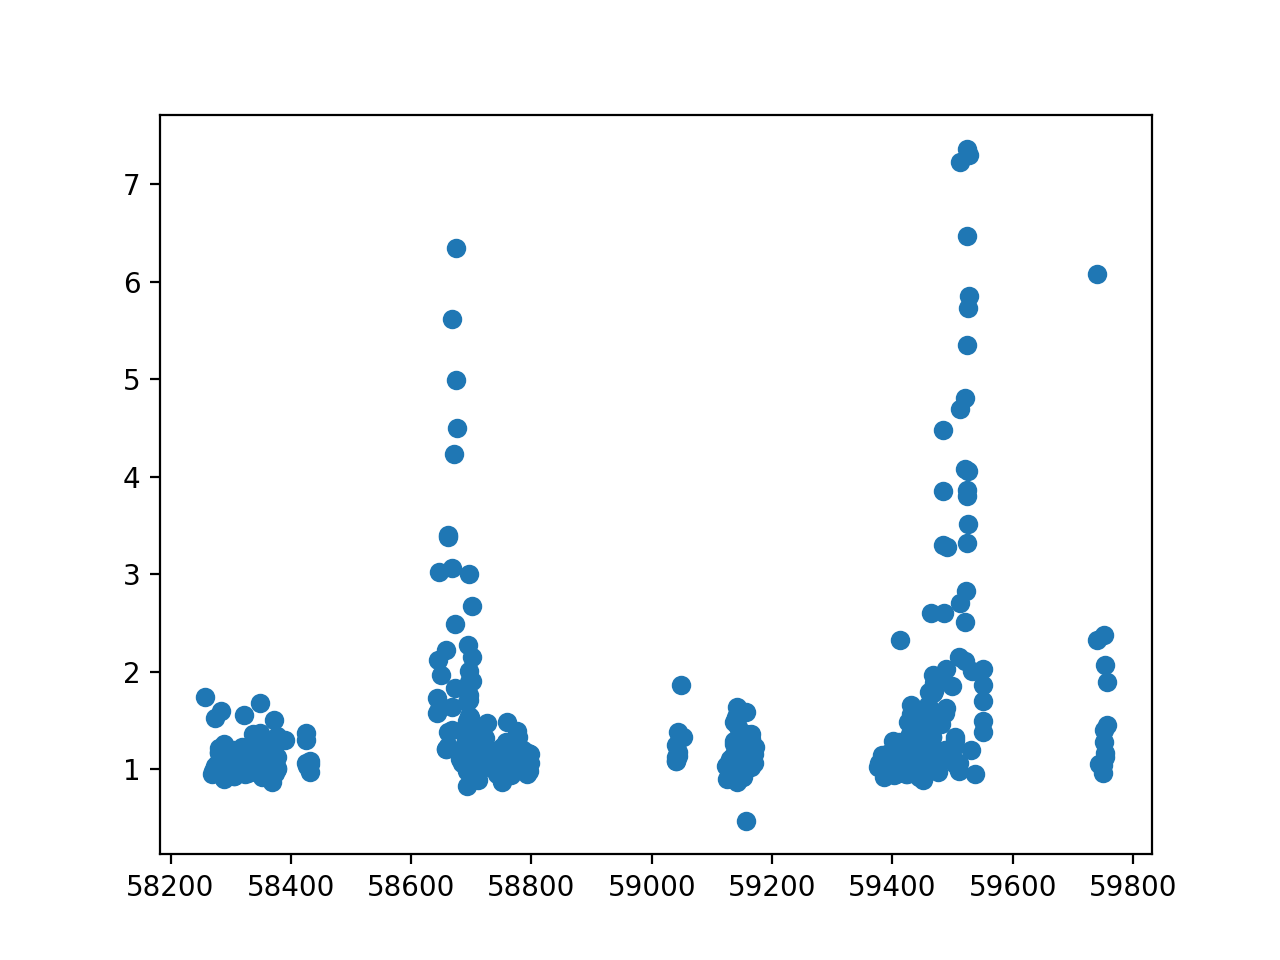

1.1460229330009601


In [25]:
plt.figure()
plt.scatter(ztf_fp['mjd'],ztf_fp['forcediffimchisq'])
print(ztf_fp['forcediffimchisq'].median())

<IPython.core.display.Javascript object>


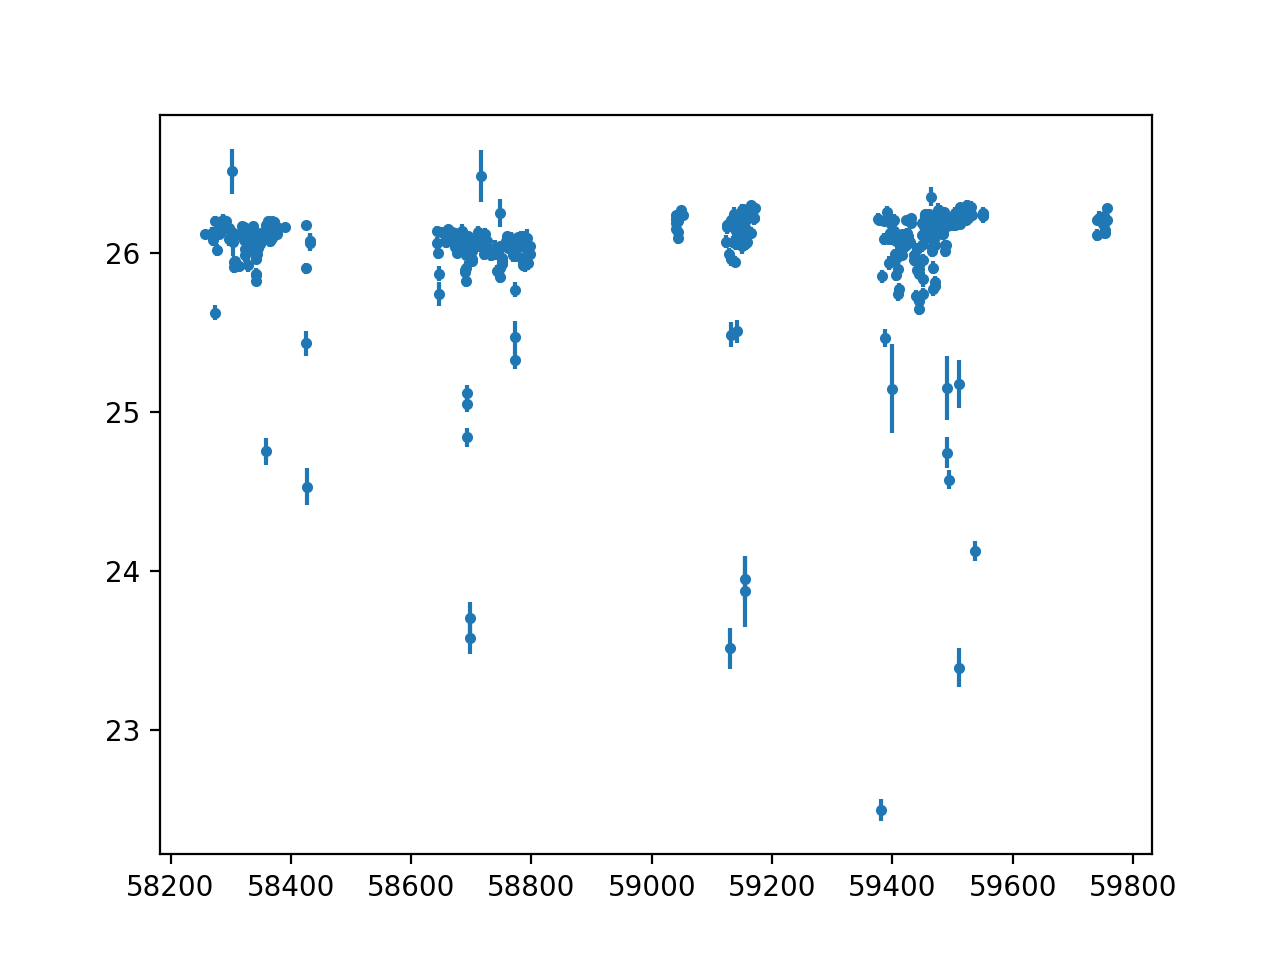

<ErrorbarContainer object of 3 artists>

In [26]:
plt.figure()
plt.errorbar(ztf_fp['mjd'],ztf_fp['zpmaginpsci'],ztf_fp['zpmaginpscirms'],fmt='.')

In [27]:
# TODO: need to check that nearest ref source is coincident and stellar
ztf_fp.loc[:,'nearestrefflux'] = 10**(0.4 * (ztf_fp['zpdiff'] - ztf_fp['nearestrefmag'])) 
ztf_fp.loc[:,'nearestreffluxunc'] = ztf_fp['nearestrefmagunc'] * ztf_fp['nearestrefflux']/ 1.0857
ztf_fp.loc[:,'dc_flux'] = ztf_fp['forcediffimflux'] + ztf_fp['nearestrefflux']
ztf_fp.loc[:,'dc_flux_err'] = np.sqrt(ztf_fp['forcediffimfluxunc']**2. - ztf_fp['nearestreffluxunc']**2.)
# fix any imaginary ones
ztf_fp.loc[ztf_fp.loc[:,'dc_flux_err'].isna(),'dc_flux_err'] = np.sqrt(ztf_fp['forcediffimfluxunc']**2. + ztf_fp['nearestreffluxunc']**2.)
ztf_fp.loc[:,'dc_snr'] = ztf_fp['dc_flux']/ztf_fp['dc_flux_err']
SNT = 3 # 3-sigma detection
SNU = 5 # 5-sigma upper limit

ztf_fp.loc[:,'dc_mag'] = np.NaN
ztf_fp.loc[:,'dc_mag_err'] = np.NaN
ztf_fp.loc[:,'dc_maglim'] = np.NaN

wzdet = ztf_fp['dc_snr'] > SNT
ztf_fp.loc[wzdet,'dc_mag'] = ztf_fp.loc[wzdet,'zpdiff'] - 2.5 * np.log10(ztf_fp.loc[wzdet,'dc_flux'])
ztf_fp.loc[wzdet,'dc_mag_err'] = 1.0857 / ztf_fp['dc_snr']

ztf_fp.loc[~wzdet,'dc_maglim'] = ztf_fp.loc[~wzdet,'zpdiff'] - 2.5 * np.log10(SNU*ztf_fp.loc[~wzdet,'dc_flux_err'])


# if we don't have reference sources the calculation is slightly different
wnoref = ztf_fp['nearestrefmag'].isna()
wnorefdet = wnoref & ((ztf_fp.loc[wnoref,'forcediffimflux'] / ztf_fp.loc[wnoref,'forcediffimfluxunc']) > SNT)
wnorefnondet = wnoref & ~((ztf_fp.loc[wnoref,'forcediffimflux'] / ztf_fp.loc[wnoref,'forcediffimfluxunc']) > SNT)

ztf_fp.loc[wnorefdet,'dc_mag'] = ztf_fp.loc[wnorefdet,'zpdiff'] - 2.5 * np.log10(ztf_fp.loc[wnorefdet,'forcediffimflux'])
ztf_fp.loc[wnorefdet,'dc_mag_err'] = 1.0857 / (ztf_fp['forcediffimflux'] / ztf_fp.loc[wnorefdet,'forcediffimfluxunc'])
ztf_fp.loc[wnorefnondet,'dc_maglim'] = ztf_fp.loc[wnorefnondet,'zpdiff'] - 2.5 * np.log10(SNU*ztf_fp.loc[wnorefnondet,'forcediffimfluxunc'])



/astro/users/ykwang/.conda/envs/alert_demo/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
plt.errorbar(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_flux'],
             ztf_fp.loc[wg,'dc_flux_err'],fmt='.',ls='none')

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

<IPython.core.display.Javascript object>


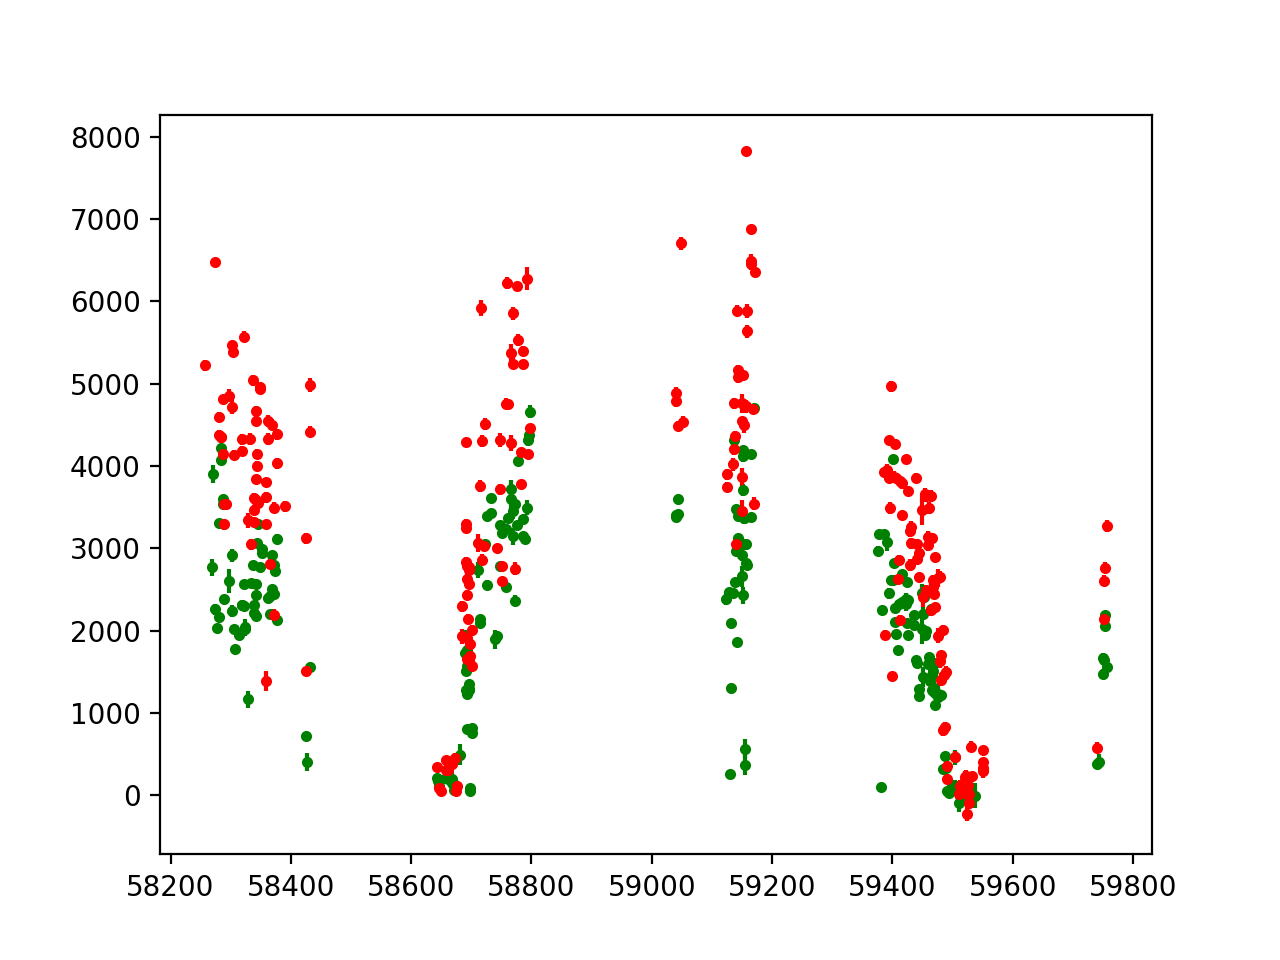

<ErrorbarContainer object of 3 artists>

In [29]:
plt.figure()
wr = ztf_fp['filter'] == 'ZTF_r'
wg = ztf_fp['filter'] == 'ZTF_g'

plt.errorbar(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_flux'],
             ztf_fp.loc[wg,'dc_flux_err'],fmt='.',ls='none', color='g')
plt.errorbar(ztf_fp.loc[wr,'mjd'],ztf_fp.loc[wr,'dc_flux'],
             ztf_fp.loc[wr,'dc_flux_err'],fmt='.',ls='none', color='r')

In [15]:
colors = ['green', 'pink', 'red']

<IPython.core.display.Javascript object>


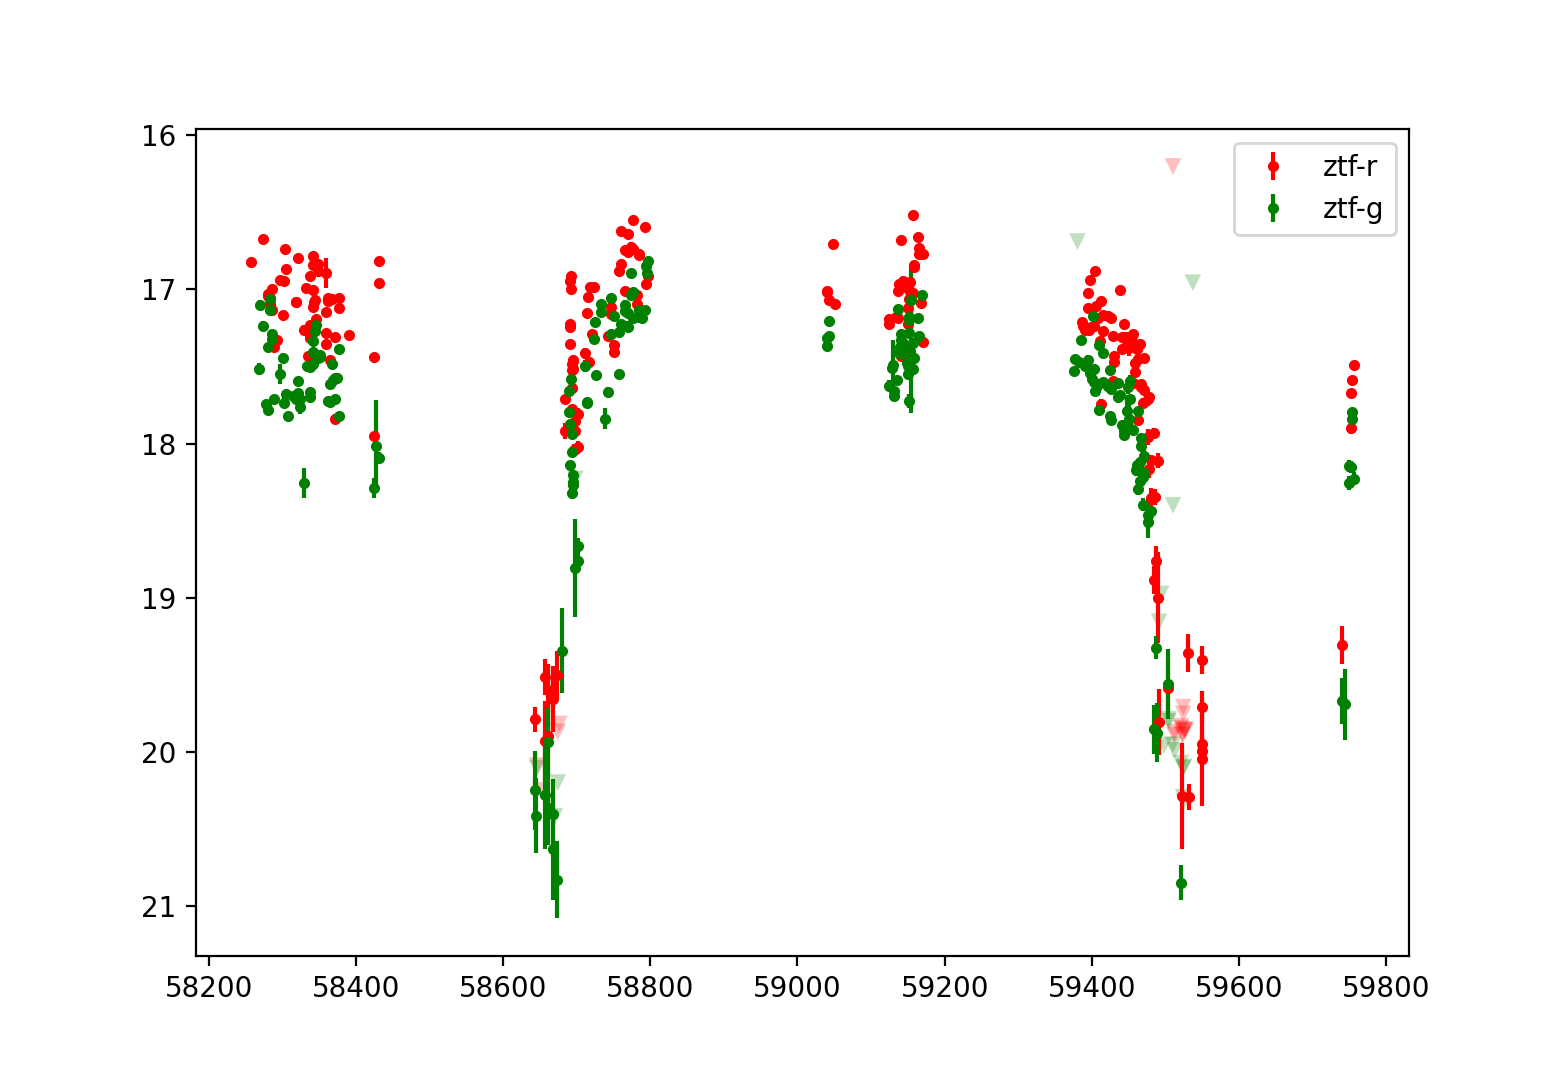

In [30]:
plt.figure()
wr = ztf_fp['filter'] == 'ZTF_r'
wg = ztf_fp['filter'] == 'ZTF_g'

plt.errorbar(ztf_fp.loc[wr,'mjd'],ztf_fp.loc[wr,'dc_mag'],
             ztf_fp.loc[wr,'dc_mag_err'],fmt='.',ls='none', color=colors[2], label='ztf-r')
plt.scatter(ztf_fp.loc[wr,'mjd'],ztf_fp.loc[wr,'dc_maglim'], marker='v',alpha=0.25,
            edgecolor='none',color=colors[2])
plt.errorbar(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_mag'],
             ztf_fp.loc[wg,'dc_mag_err'],fmt='.',ls='none', color=colors[0], label='ztf-g')
plt.scatter(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_maglim'], marker='v',alpha=0.25,
            edgecolor='none',color=colors[0])

# plot cases without a reference
# plt.errorbar(ztf_fp.loc[wr&wnoref,'mjd'],ztf_fp.loc[wr&wnoref,'dc_mag'],
#              ztf_fp.loc[wr&wnoref,'dc_mag_err'],fmt='.',ls='none', color=colors[2])
# plt.scatter(ztf_fp.loc[wr&wnoref,'mjd'],ztf_fp.loc[wr&wnoref,'diffmaglim'], marker='v',alpha=0.25,
#             edgecolor='none',color=colors[2])
# plt.errorbar(ztf_fp.loc[wg&wnoref,'mjd'],ztf_fp.loc[wg&wnoref,'dc_mag'],
#              ztf_fp.loc[wg&wnoref,'dc_mag_err'],fmt='.',ls='none', color=colors[0])
# these no-ref limits seem to be spurious
#plt.scatter(ztf_fp.loc[wg&wnoref,'mjd'],ztf_fp.loc[wg&wnoref,'diffmaglim'], marker='v',alpha=0.25,
#            edgecolor='none',color=colors[0])

# TODO: consider marking bad points (procstatus !=0)
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel()

In [103]:
ztf_fp.query('59745 > mjd').groupby('filter')[['dc_mag', 'dc_mag_err']].count()

,dc_mag,dc_mag_err
filter,,
ZTF_g,13,13
ZTF_r,15,15


In [94]:
59748.367581 + 2400000.5

2459748.867581

In [95]:
ztf_fp[ztf_fp['mjd'] > 59749][['filter', 'mjd']]

,filter,mjd
index,,
30,ZTF_g,59750.330521
31,ZTF_r,59750.359942


In [16]:
pd.to_datetime(ztf_fp.set_index('filter').query('59743 < mjd')['mjd'] + 2400000.5, unit='D', origin='julian')

filter
ZTF_r   2022-06-13 07:37:25.996800
ZTF_g   2022-06-13 09:25:32.001600
ZTF_r   2022-06-18 08:49:18.998400
ZTF_g   2022-06-18 09:32:57.998400
ZTF_g   2022-06-20 07:55:56.997120
ZTF_r   2022-06-20 08:38:18.997440
ZTF_r   2022-06-22 10:00:40.999680
Name: mjd, dtype: datetime64[ns]

In [56]:
np.sum(ztf_fp.dc_snr > 3)

32

In [67]:
ztf_fp['dc_snr'].hist()

<AxesSubplot:>

In [17]:
ztf_fp.iloc[-1]

field                            1483
ccdid                              13
qid                                 2
filter                          ZTF_r
pid                     1998417145015
infobitssci                         0
sciinpseeing                   1.8844
scibckgnd                     242.012
scisigpix                     9.43395
zpmaginpsci                   26.2502
zpmaginpsciunc             2.3525e-06
zpmaginpscirms              0.0141879
clrcoeff                    0.0769942
clrcoeffunc               6.56088e-06
ncalmatches                      1835
exptime                            30
adpctdif1                    0.064232
adpctdif2                    0.053677
diffmaglim                     20.299
zpdiff                        26.2502
programid                           2
jd                        2.45975e+06
rfid                       1483120250
forcediffimflux               153.099
forcediffimfluxunc            30.3836
forcediffimsnr                5.60515
forcediffimc